# Ensembles: Bringing It All Together
## Localised Linear Regression

Firstly, what are ensemble models? 
Ensemble models use multiple learning algorithms to aid in the accuracy of prediction. In many cases this will come in the form of combining the outputs of multiple models in some way - we have seen this previously in the tutorial on random forests which combine the predictive output of multiple decision tress (Machine Learning algorithms in and of themselves) to improve accuracy of the final output.

In this tutorial we will combine simple linear regression with nearest neighours algorithms. Its a simple idea which we will illustrate in several cases. Taking a simple case first will lay the groundwork for thinking about combining models to improve predictive power.

**Note:** The output of this notebook is random so re run it a few times to see different outputs. This has been done to demonstrate that the examples are not cherry picked and ultimately adding randomness and distributing enables faster testing by anyone who runs this notebook, testing on the edge à la A/B testing.

### Setup
Given that we are using multiple models the imports for our program have grown. We bring in nearest neighbours, linear regression and the general data management and visualisation tools (Pandas, MatPlotLib and Seaborn - A library for smoothing the standard styles of MatPlotLib).
Note that throughout this notebook we implicitly use NumPy as it gets imported with Pandas. We do this thorough `pd.np`.

In [1]:
%matplotlib inline
import random, seaborn; import pandas as pd
from sklearn.linear_model import LinearRegression; from sklearn.neighbors import NearestNeighbors, RadiusNeighborsRegressor
import matplotlib.pyplot as plt
np = pd.np

A final bit of set up. We apply the Seaborn styling and change the size of the matplotlib plots to be larger 6 x 9 (_h_ x _w_). This is a useful trick for making charts presentable without having to stretch the output bitmaps and manage images on a chart by chart basis.

In [2]:
seaborn.set()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9; fig_size[1] = 6

### Ordinary Least Squares (OLS)
The statistitian's standard tool of linear least squares regression provides a lot of power, closed form solutions for parameters and with a few simple modifications it can handle heteroskedastic distributions. However, it is not a tool for all problems as one may expect given the name, it is only really suited to linear combinations of (transformations of) the observable variables.

Being simple, fast and easy to interpret OLS is often a good place to start to get an idea of one's data and any possible trends. We have already covered the implementation of OLS in python so let's set up a problem and see how far it gets us.

Let's pick a relatively simple yet nonlinear mathematical function and see how OLS copes. In this case we consider the Sine curve (stretched a little to aid our presentation).

$$y=\sin\left(\frac{x}{4}\right)$$

We then pick a series of 880 points as our 'sample' and will try to learn what the underlying function mapping $x$ to $y$ is.

In [3]:
domain = np.arange(0,88,0.1)
sin_curve = np.sin(0.25 * domain)

Anyone working with data will tell you that a picture is worth a thousand words so lets just plot our data and see what we're working with.

Text(0.5,1,'The Sine Curve')

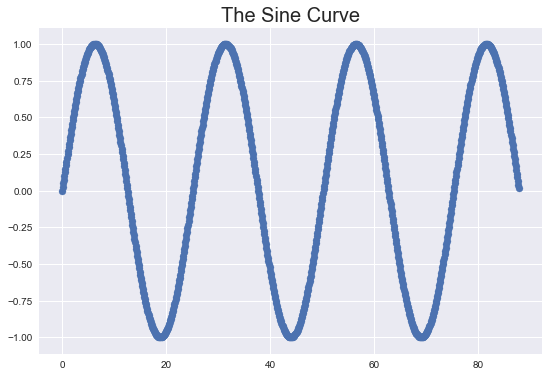

In [4]:
plt.scatter(domain, sin_curve)
plt.title('The Sine Curve', fontsize=20)

### Applying the model
Time to naively build a model and hope for the best. 

Let's apply OLS to the sine curve and see where it gets us...

In [5]:
simple_linear_regression = LinearRegression()
simple_linear_regression.fit(domain.reshape(-1,1), sin_curve.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

As a basic understanding of linear regression will tell us, trying to fit a stright line to this data will not tell us very much. In fact it will probably just return the sample mean as a best estimate as the nonlinear process is too complex for linear regression to handle.

We can see that this is what has been done by considering the mean and the slope of the fit to the data.

In [6]:
predictions = simple_linear_regression.intercept_ + simple_linear_regression.coef_[0] * domain
print('Intercept:\t', simple_linear_regression.intercept_[0])
print('Slope:\t\t', simple_linear_regression.coef_[0][0])
print('Sample Average:\t', sin_curve.mean())

Intercept:	 0.0906979174388081
Slope:		 4.771039813372856e-06
Sample Average:	 0.09090760463860584


The sample average and the intercept are almost the same and the slope of the presumed relationship is more or less zero. Clearly we are doing little better than simply taking an average and using this for all points. More on this later.

First, let's plot the outcomes of this initial analysis.

Text(0.5,1,'A Global Regression Fit')

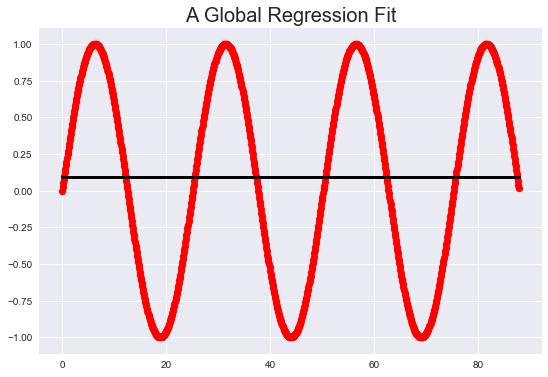

In [7]:
plt.scatter(domain, sin_curve, c='r', edgecolors='r')
plt.plot(domain, predictions, 'k-', lw=3)
plt.title('A Global Regression Fit', fontsize=20)

As the plot shows we have really learnt nothing of the Sine curve's shape. A poor show for a standard tool of statistics (improperly applied of course).

To see how much of the variance in the data we are actually explaining let's calcuate the $R^2$ for our model.

In [8]:
simple_linear_regression.score(domain.reshape(-1,1), sin_curve.reshape(-1,1))

2.9885152907915824e-08

Seems we're explaining basically none of the variance in our data.

Do we need to start again or can we reapply linear regression in a different way to improve our results?

Forwards ever, backwards never. Let's press on.

## Updating Least Squares
### Using Big Data to 'Zoom In'
In this case we have 880 examples, not exactly big data per se but enough data to try to 'zoom in'. This is the concept that it may be better to use a subset of data for each prediction. Since using the entire data set didn't get us very far maybe less is more. What if we chose to take only those points most similar (read closest) to the one for which we aim to predict a value? This makes intuitive sense because in this case we are using linear regression to approximate the function in our area of interest. As long as we do not extrapolate too far this could work.

First of all we need to find the 'most similar' points that we will use for each regression problem. This is a problem of nearest neighbours.

Let's begin this new approach by setting up a nearest neighbours model. We'll take the 40 nearest points and use them to build a regression each time. The optimal number of points to fit to may vary at different points in the data set and is itself a parameter for optimisation. In this case 40 proves our point. 

We conduct a brute force search on each query. This means that the (Euclidean) distance to every other point in the data set is calculated and then the closest 40 points are returned. Clearly this may be very slow in a larger dataset but given we have fewer than 1,000 examples this shouldn't be too taxing.

In [9]:
neighbours = NearestNeighbors(n_neighbors = 40, algorithm='brute')

Having set up the neighbours model we need to give it some data to which to fit. Since we must look for close neighbours over some (series of) dimension(s) we give the model the $x$ data for the model. We cannot also compare on the $y$-coordinate since we will be querying the model with an $x$ value for which we aim to preidct the $y$ and hence we may not compare in the $y$ dimension.

In [10]:
neighbours.fit(domain.reshape(-1,1))

NearestNeighbors(algorithm='brute', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=40, p=2, radius=1.0)

The return value from this cell tells us that we are using a brute force search `algorithm='brute'` and that we are using the Euclidean distance measure. This is inferred by use of the Minkowski distance with a $p$ parameter of 2 (`metric='minkowski`, `p=2`). This follows from the definition of the Minkowski metric as below:
$$D(x, y)=\left(\sum_{i=1}^n{\lvert x_i - y_i\rvert}^p\right)^{\frac{1}{p}}$$

Clearly in the case of $p=2$ this is the square root of the sum of squared differences i.e. the Euclidian distance between $x$ and $y$. We are applying this in one dimension so the absolute difference in value would suffice.

Now we can test out the new idea of localised regression. Let us pick a point at random (within our range) and try to fit to it.

First we pick the point and then we get its neighbours (note that the SciKit Learn package's nearest neighbour object returns the indices of the nearest neighboutrs within the data given to the model, hence the original training data must be retained in order to retrieve the values of the neighbouring points).

In [11]:
point = random.random() * 88 
indices = neighbours.kneighbors(point, return_distance=False)

Now that we have the values in the neighbourhood of our point of interest let's fit a linear regression using just these points and see how well it does by considering the coefficient of determination.

In [12]:
local_regression = LinearRegression()
local_regression.fit(domain[indices].reshape(-1,1), sin_curve[indices].reshape(-1,1))
local_regression.score(domain[indices].reshape(-1,1), sin_curve[indices].reshape(-1,1))

0.9625637474019705

Now that we have our model let's visualise what we have done by plotting the straight line we have estimated and expanding it out beyond the neighbourhood of data we used to make the line more noticeable.

In [13]:
minimum = domain[indices].min(); maximum = domain[indices].max()
extended_range = 1.5 * (maximum - minimum)
start = (maximum + minimum)/2 - extended_range/2
local_domain = np.arange(start, start+extended_range, extended_range/10).reshape(-1,1)
local_predictions = local_regression.predict(local_domain)

Text(0.5,1,'Local Regression Fit')

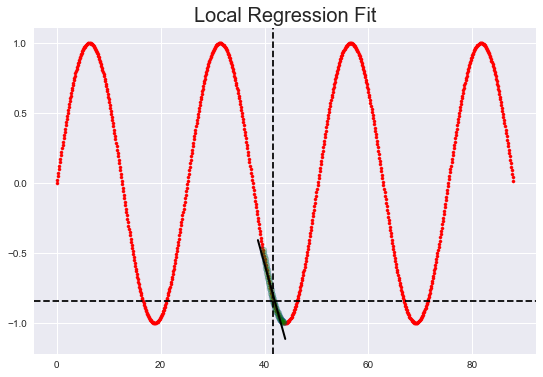

In [14]:
plt.scatter(domain, sin_curve, s=10, c='r', edgecolors='r')
plt.scatter(domain[indices], np.sin(domain[indices]/4), c='g', alpha=0.3, edgecolors='b')
plt.plot(local_domain, local_predictions, 'k-', lw=2)
plt.axvline(x=point, c='k', linestyle='--')
plt.axhline(y=np.sin(0.25 * point), c='k', linestyle='--')
plt.title('Local Regression Fit', fontsize=20)

The previous plot shows that our localised regression has successfully approximated the Sine curve in the neighbourgood of our point. The further the extrapolation the greater the error. In fact the plot showed that it may be better to fit to a smaller neighbourhood so that the approximation is even more localised and hopwfully more accurate. This demonstrates the trade off between the neighbourhood size and therefore the ability to avoid fitting to noise (of which there is none in this case) and the abstraction from global patterns which may be misleading.
#### To Sum Up
Let's consider how much 'zooming in' improved the predictive power of our model. 

While the output will be random given the setup of this notebook the localised regression should be a much better model. This shows the power of localised trends over a global trend in some cases. Something to look out for in future analysis if the global models aren't working too well.

In [15]:
print('Point: ', point)
print('Global Regression Prediction: ', simple_linear_regression.predict(point)[0][0])
print('Local Regression Prediction: ', local_regression.predict(point)[0][0])
print('True Value: ', np.sin(0.25 * point))

Point:  41.698128200441516
Global Regression Prediction:  0.09089686086859554
Local Regression Prediction:  -0.8069055638250218
True Value:  -0.8413380932704015


### Use Cases
This ability to abstract from having to generalise globally can clearly be useful in many cases. For example there may be structural breaks in the data or indeed too complex a relationship to fit with limited models.

In this section we consider the case of a kinked relationship where the interaction of $x$ and $y$ is not consistent over the domain of interest and as such localisation can enable a better fit by fitting to the relationship either side of the kink with the greatest issue at the point of discontinuity. However even at this point if the neighbourhood considered is small enough the error (compared to fitting a global regression model) should be reduced by localisation. 

Clearly if the location of the point of discontinuity can be determined then we can do much better by accounting for it explicitly however this may not always be possible. When working in many dimensions the features may interact in complex ways, too complex to account for in preprocessing and hence a model robust to such problems is great. Our model of localised regression can be good for such cases.

Let us generate this case by setting a random point of discontunity (a kink) and having a different (noisy) relationship either side of the randomly chosen point.

In [16]:
x = np.arange(0,100,0.25)
y = 7 + 0.1 * np.arange(0,100,0.25)
k = random.randint(10,90)
y += np.append(np.zeros(4 * k), 2 * np.arange(0, 100-k, 0.25))
y += np.random.normal(0, 3, 400)

We may now visualise the problem we have to deal with.

Text(0.5,1,'Discontinuous Relationships')

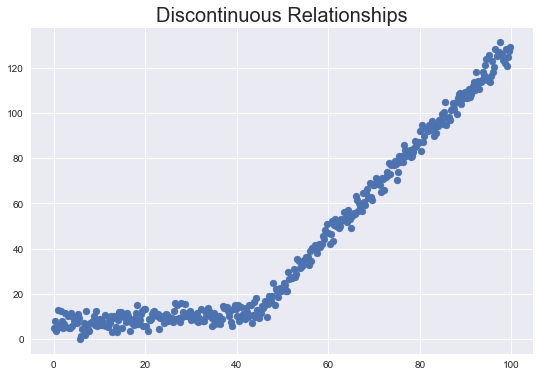

In [17]:
plt.scatter(x, y)
plt.title('Discontinuous Relationships', fontsize=20)

As a baseline point of comparison let us fit a global regression and use it to predict outcomes. We will plot this estimated relationship later.

In [18]:
global_regression = LinearRegression()
global_regression.fit(x.reshape(-1,1), y.reshape(-1,1))
y_pred = global_regression.predict(x.reshape(-1,1))

Now to test the efficacy of our modelling we pick a point to the left of the kink (a) and a point to the right (b). The two points will therefore test the model under the two different regimes of the relationship between $x$ and $y$. The model will also be tested at the point of discontinuity (k).

Note that random.random() yields a value on the unit interval and hence $ a \lt k \lt b $.

In [19]:
a = k * random.random()
b = k + (100 - k) * random.random()

From this point we may then set up our nearest neighbours model and give it the $x$ data to work with. 

In [20]:
kink_neighbours = NearestNeighbors(n_neighbors=50)
kink_neighbours.fit(x.reshape(-1,1))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=50, p=2, radius=1.0)

Now we have all we need to test out our model.

First we gather the neighbours of each point and place them into a pandas dataframe so we may manipulate and access them easily.

In [21]:
local_plots = pd.DataFrame(index=range(50), columns=['a_indices', 'a_domain', 'a_values', 'k_indices', 'k_domain', 'k_values', 'b_indices' 'b_domain', 'b_values'])
local_plots['a_indices'] = kink_neighbours.kneighbors(a, return_distance=False)[0]
local_plots['k_indices'] = kink_neighbours.kneighbors(k, return_distance=False)[0]
local_plots['b_indices'] = kink_neighbours.kneighbors(b, return_distance=False)[0]

We may now fit a linear regression to each of these points of neigbourhoods in turn.

In [22]:
local_regression = LinearRegression()
local_regression.fit(x[local_plots.a_indices].reshape(-1,1), y[local_plots.a_indices].reshape(-1,1))
local_plots.a_domain = x[local_plots.a_indices]
local_plots.a_values = local_regression.predict(local_plots.a_domain.values.reshape(-1,1))
del local_regression

In [23]:
local_regression = LinearRegression()
local_regression.fit(x[local_plots.k_indices].reshape(-1,1), y[local_plots.k_indices].reshape(-1,1))
local_plots.k_domain = x[local_plots.k_indices]
local_plots.k_values = local_regression.predict(local_plots.k_domain.values.reshape(-1,1))
del local_regression

In [24]:
local_regression = LinearRegression()
local_regression.fit(x[local_plots['b_indices']].reshape(-1,1), y[local_plots.b_indices].reshape(-1,1))
local_plots['b_domain'] = x[local_plots.b_indices]
local_plots['b_values'] = local_regression.predict(local_plots.b_domain.values.reshape(-1,1))
del local_regression

### Plotting Our Success
The the following plot shows how well we have managed to fit either side of the discontinutity. What's more the fit at the kink isn't bad either.

The plot highlights how inflexible OLS is when bluntly applied but how a simple and intuitive trick can make this stock model far more flexible.

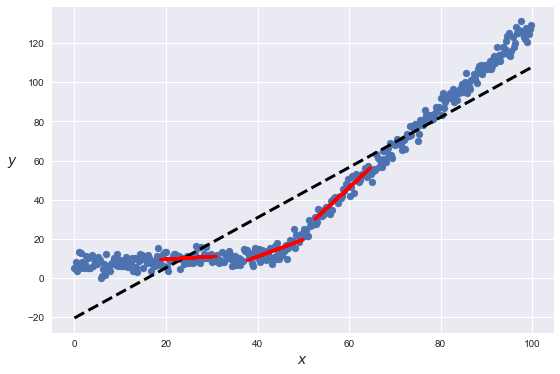

In [25]:
plt.scatter(x, y)
plt.plot(x, y_pred, 'k--', lw=3)
plt.plot(local_plots.a_domain, local_plots.a_values, 'r-', lw=3)
plt.plot(local_plots.k_domain, local_plots.k_values, 'r-', lw=3)
plt.plot(local_plots.b_domain, local_plots.b_values, 'r-', lw=3)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14, labelpad=15).set_rotation(0)

### Another Way?
Sci-Kit Learn has its own tool to do this (`RadiusNeighborsRegressor`). It performs the same job but looks for points within a fixed radius within which to interpolate rather than for a fixed number of neighbours. This aids in reducing the possibility of looking too far afield where the data is spread out. 

In [26]:
radius_regressor = RadiusNeighborsRegressor(radius=1, algorithm='brute')
radius_regressor.fit(domain.reshape(-1,1), np.sin(domain).reshape(-1,1))

RadiusNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
             metric_params=None, p=2, radius=1, weights='uniform')

Let's see how this performs vs vanilla OLS by returning to the Sine curve. We trained it on the same domain above.

Remember that our previous investigation saw very poor performance for OLS when fitting the Sine curve ($R^2_{OLS}\approx3\times10^{-8}$).

In [27]:
radius_regressor.score(domain.reshape(-1,1), np.sin(domain).reshape(-1,1))

0.9695075273235192

This does indeed perform much better and on a par with our (semi-) manually built ensemble. A little more fine tuning of the hyperparameters and there should be little difference between the radius regression and the handmade nearest neighbours regression ensemble.

**Note:** The comparison of the $R^2$ for our handmade ensemble is somewhat unfair since we only consider the fit to and around one point.

$$R^2_{OLS}\approx3\times10^{-8}\ \ \ \ R^2_{radius}\approx0.97\ \ \ \ R^2_{neighbours}\approx0.96$$

We may see that many good ideas have been built into common packages already. You can learn a lot from the documentation and playing with the models with a friendly syntax. Its a highly recommended learning tool before you branch off on your own.

Think creatively and you can get far more mileage out of the models you know before stepping into the unknown.